In [1]:
# basic libraries
import itertools
import re
import string

# data processing 
import collections
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import unicodedata
import html
import datetime

# natural language pre-processing 
from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer

# ML pipelines
from transformers import pipeline

# sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# data visualization
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from wordcloud import WordCloud, STOPWORDS



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macarthur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macarthur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Define function for text data cleaning:

In [2]:
def clean_text(text_list):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text_list.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # strip html
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()


## Define function for sentiment analysis:

In [3]:
# get analysis from a pandas series: albert-v2 embeddings

def sentiment_albert(dataframe_col):
    # create sentiment classifier from pretrained model "albert-base-v2-emotion"
    classifier = pipeline("text-classification",model='bhadresh-savani/albert-base-v2-emotion', return_all_scores=True)
    # create dataframe structure for sentiment analysis results
    albert_column_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    df_albert = pd.DataFrame(columns = albert_column_names)
    score_sadness = []
    score_joy = []
    score_love = []
    score_anger = []
    score_fear = []
    score_surprise = []

    for i in dataframe_col:
        pred = classifier(i)
        pred = pred[0]
        score_sadness.append(pred[0]['score'])
        score_joy.append(pred[1]['score'])
        score_love.append(pred[2]['score'])
        score_anger.append(pred[3]['score'])
        score_fear.append(pred[4]['score'])
        score_surprise.append(pred[5]['score'])
        # pred_l.append(pred[0]['socore'])


    df_albert["sadness"] = score_sadness
    df_albert["joy"] = score_joy
    df_albert["love"] = score_love
    df_albert["anger"] = score_anger
    df_albert["fear"] = score_fear
    df_albert["surprise"] = score_surprise
    return df_albert

In [86]:
# plot sentiment analysis results of a user: albert-v2 embeddings

def plot_user_sentiment(df, userid):
    df_user = df.loc[df['user'] == userid]
    # on user level
    # run sentiment analysis function, save analysis results as a new df
    df_albert_user = sentiment_albert(df_user['text'])
    # append time data from original dataframe
    df_albert_user['timecode_by_seconds'] = df_user['ts']
    df_albert_user = df_albert_user.dropna(subset=['timecode_by_seconds'])
    df_albert_user['datetime'] = pd.to_datetime(df_albert_user['timecode_by_seconds'], unit='s')
    df_albert_user.resample('D', on='datetime').mean()
    df_albert_user_d = df_albert_user.resample('D', on='datetime').mean()
    df_albert_user_d = df_albert_user_d.drop(columns=['timecode_by_seconds']).fillna(method='bfill')
    return df_albert_user_d.plot()

In [87]:
# read csv
df = pd.read_csv('../csv/data_raw.csv')
df_sent = df.copy()

In [88]:
# preprocess text data
df_sent['text'] = df_sent['text'].astype(str)
stop = stopwords.words('english')
df_sent['text'] = df_sent['text'].apply(clean_text)

In [41]:
# run sentiment analysis function, save analysis results as a new df
df_albert = sentiment_albert(df_sent['text'])
# append time data from original dataframe
df_albert['timecode_by_seconds'] = df_sent['ts']
df_albert.head()

,sadness,joy,love,anger,fear,surprise,timecode_by_seconds
0,0.072539,0.415985,0.021461,0.305852,0.167026,0.017137,1.616237e+09
1,0.177684,0.157180,0.172585,0.178552,0.167154,0.146846,1.617897e+09
2,0.076251,0.078906,0.014845,0.525952,0.290061,0.013985,1.620900e+09
3,0.058233,0.083558,0.010807,0.703634,0.135241,0.008528,1.620200e+09
4,0.039806,0.029209,0.009691,0.820785,0.095187,0.005322,1.620211e+09


In [92]:
# look at list of user ids
userid_list = df_sent['user'].tolist()
userid_list

['U01S1CWGTU4',
 'U01S7BM4N81',
 'U01RXCQHMHT',
 'U01S7KCL3DF',
 'U01RSRE0N3D',
 'U01RW2X7S9Z',
 'U01S7BM4N81',
 'U01S7BM4N81',
 'U01S7BM4N81',
 'U01RW2X7S9Z',
 'U01S081EULS',
 'U01S7KCL3DF',
 'U01S7BM4N81',
 'U01S7KCL3DF',
 'U01S081EULS',
 'U01S7KCL3DF',
 'U01S0P26NKD',
 'U01RXCQHMHT',
 'U01RW2X7S9Z',
 'U01RXCQHMHT',
 'U01RXCQHMHT',
 'U01RW2X7S9Z',
 'U01RW2X7S9Z',
 'U01RW2X7S9Z',
 'U01RXCQHMHT',
 'U01RXCQHMHT',
 'U01S7KCL3DF',
 'U01RSRE0N3D',
 'U01RRV4JX6Z',
 'U01RXCQHMHT',
 'U01S7KCL3DF',
 'U01S7BM4N81',
 'U01S79YDELR',
 'U01S7BM4N81',
 'U01S081EULS',
 'U01S79YDELR',
 'U01RW2X7S9Z',
 'U01RXCQHMHT',
 'U01RKN0EGDV',
 'U01RXCQHMHT',
 'U01RXCQHMHT',
 'U01RSRE0N3D',
 'U01RSRE0N3D',
 'U01RRV4JX6Z',
 'U01RW140HBP',
 'U01S1CWGTU4',
 'U01S1CWGTU4',
 'U01RKN0EGDV',
 'U01RW2X7S9Z',
 'U01RKN0EGDV',
 'U01RKN0EGDV',
 'U01RXCQHMHT',
 'U01RKN0EGDV',
 'U01RRV4JX6Z',
 'U01S1CWGTU4',
 'U01S1CWGTU4',
 'U01RRV4JX6Z',
 'U01S1CWGTU4',
 'U01S1CWGTU4',
 'U01RW2X7S9Z',
 'U01RSRE0N3D',
 'U01RXCQHMHT',
 'U01RXC

<AxesSubplot:xlabel='datetime'>

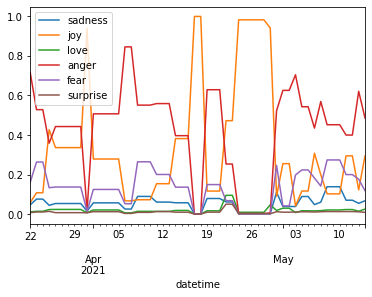

In [97]:
# run user-specific sentiment changes over time and plot the results
plot_user_sentiment(df_sent, 'U01S7KCL3DF')

In [42]:
# saving results to csv
df_albert.to_csv('sentiment_albert-v2.csv')